# New York City Taxi Trip Duration solution

This is my solution for the Kaggle competition: https://www.kaggle.com/c/nyc-taxi-trip-duration

This solution ranked 49 of 1257 (Top 4%). This solution uses a linear combination of several lightGBM regressor with different random seeds. 

## Exploratory Data Analysis and Feature Extraction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import gc

sns.set()

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')

df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])

#drop redundant column
df_train = df_train.drop('dropoff_datetime', axis = 1)

df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


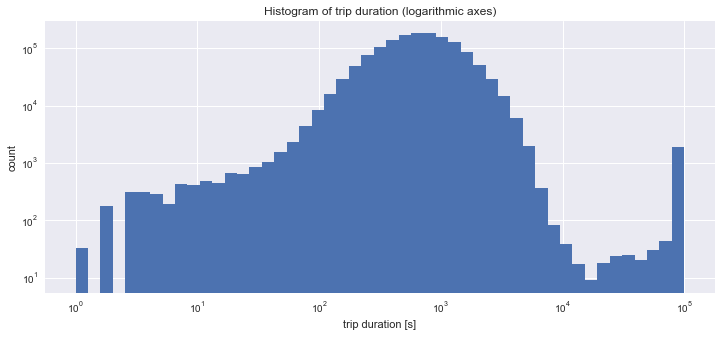

In [4]:
plt.figure(figsize = (12, 5))
plt.hist(x = df_train.trip_duration, bins = np.logspace(np.log10(1),np.log10(100000), 50))

plt.title('Histogram of trip duration (logarithmic axes)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('trip duration [s]')
plt.ylabel('count')

plt.show()

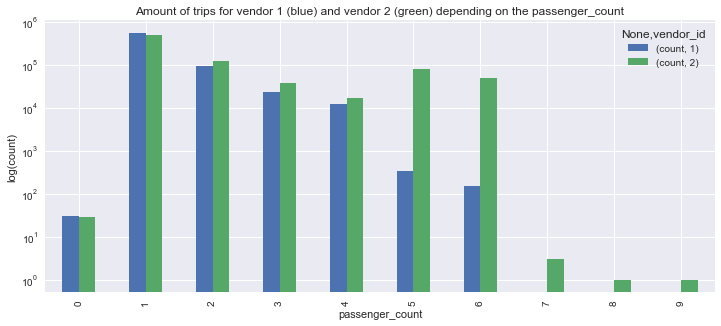

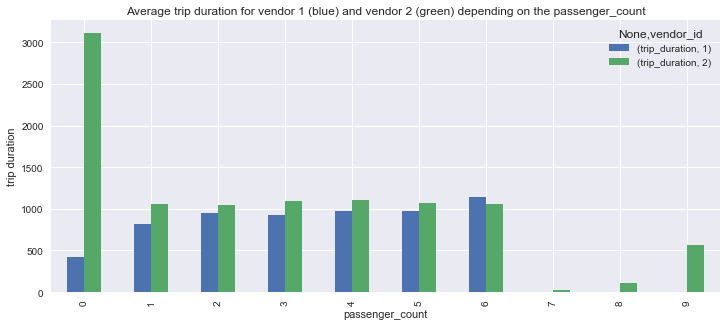

In [5]:
df_train[['vendor_id', 'passenger_count', 'id']].groupby(['passenger_count', 'vendor_id']).id.agg(['count']) \
    .unstack().plot(kind = 'bar', figsize = (12, 5))

plt.title('Amount of trips for vendor 1 (blue) and vendor 2 (green) depending on the passenger_count')
plt.ylabel('log(count)')
plt.yscale('log')
plt.show()

df_train[['vendor_id', 'passenger_count', 'trip_duration']] \
    .groupby(['passenger_count', 'vendor_id']).agg(np.mean) \
    .unstack().plot(kind = 'bar', figsize = (12, 5))

plt.title('Average trip duration for vendor 1 (blue) and vendor 2 (green) depending on the passenger_count')
plt.ylabel('trip duration')
plt.show()

# Coordinates

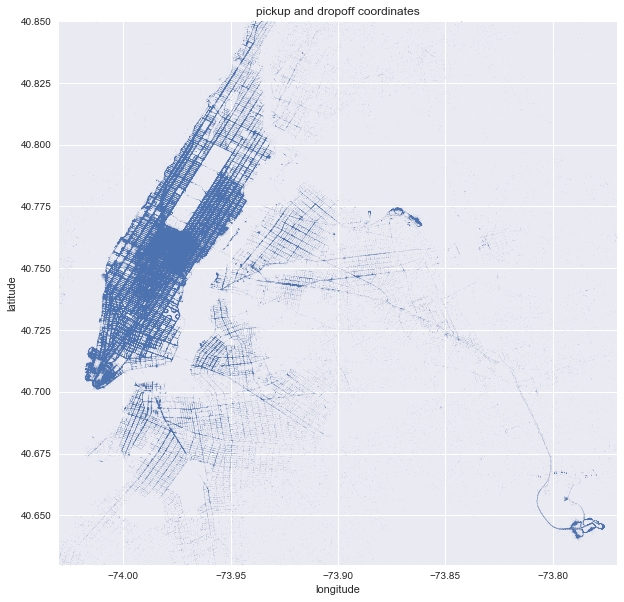

In [6]:
min_lo = -74.03 #-75
max_lo = -73.77 #-73
min_la = 40.63 # 40.2
max_la = 40.85 #41.5

plt.figure(figsize = (10,10))

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

plt.plot(list(df_train.pickup_longitude) + list(df_train.dropoff_longitude), 
         list(df_train.pickup_latitude) + list(df_train.dropoff_latitude),
         '.', alpha = 0.4, markersize = 0.5)

plt.title('pickup and dropoff coordinates')
plt.xlim(min_lo, max_lo)
plt.ylim(min_la, max_la)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [7]:
from geopy.distance import great_circle

def direction_array(la1, lo1, la2, lo2):
    AVG_EARTH_RADIUS = 6371 
    lo_delta_rad = np.radians(lo2 - lo1)
    la1, lo1, la2, lo2 = map(np.radians, (la1, lo1, la2, lo2))
    y = np.sin(lo_delta_rad) * np.cos(la2)
    x = np.cos(la1) * np.sin(la2) - np.sin(la1) * np.cos(la2) * np.cos(lo_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

def add_distance_features(data):
    data.loc[:, 'distance'] = data.apply(lambda x: great_circle((x['pickup_longitude'],  x['pickup_latitude']),
                                                                (x['dropoff_longitude'], x['dropoff_latitude'])
                                                               ).meters, 
                                         axis=1
                                        )
    data.loc[:, 'distance_la'] = data.apply(lambda x: great_circle((x['pickup_longitude'], x['pickup_latitude']),
                                                                   (x['pickup_longitude'],  x['dropoff_latitude'])
                                                                  ).meters, 
                                            axis=1
                                           )
    data.loc[:, 'distance_lo'] = data.apply(lambda x: great_circle((x['pickup_longitude'], x['pickup_latitude']),
                                                                   (x['dropoff_longitude'], x['pickup_latitude'])
                                                                  ).meters, 
                                            axis=1
                                           )
    data.loc[:, 'dir'] = direction_array(data['pickup_latitude'].values, data['pickup_longitude'].values, 
                                  data['dropoff_latitude'].values, data['dropoff_longitude'].values,
                                 )
    
    data.loc[:, 'avg_longitude'] = np.mean([data['pickup_longitude'], data['dropoff_longitude']])
    data.loc[:, 'avg_latitude'] = np.mean([data['pickup_latitude'], data['dropoff_latitude']])
    
    return data

df_train = add_distance_features(df_train)
df_test = add_distance_features(df_test)

Next a princical component analysis is used on the longitude and latitude coordinates. This part is taken from beluga's awesome 'From EDA to the Top' kernel: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367. This idea came originally from Nir Maldin.

He arguments that the rotation could help the decision trees to split the coordinates from a different angle.

In [9]:
from sklearn.decomposition import PCA

coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values
                   ))

pca = PCA().fit(coords)

def add_pca_features(data):
    data.loc[:, 'pickup_pca0']  = pca.transform(data[['pickup_latitude', 'pickup_longitude']])[:, 0]
    data.loc[:, 'pickup_pca1']  = pca.transform(data[['pickup_latitude', 'pickup_longitude']])[:, 1]
    data.loc[:, 'dropoff_pca0'] = pca.transform(data[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    data.loc[:, 'dropoff_pca1'] = pca.transform(data[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    data.loc[:, 'pca_manhattan'] = np.abs(data['dropoff_pca1'] - data['pickup_pca1']) \
                                 + np.abs(data['dropoff_pca0'] - data['pickup_pca0'])
    
    return data
                        
df_train = add_pca_features(df_train)
df_test = add_pca_features(df_test)

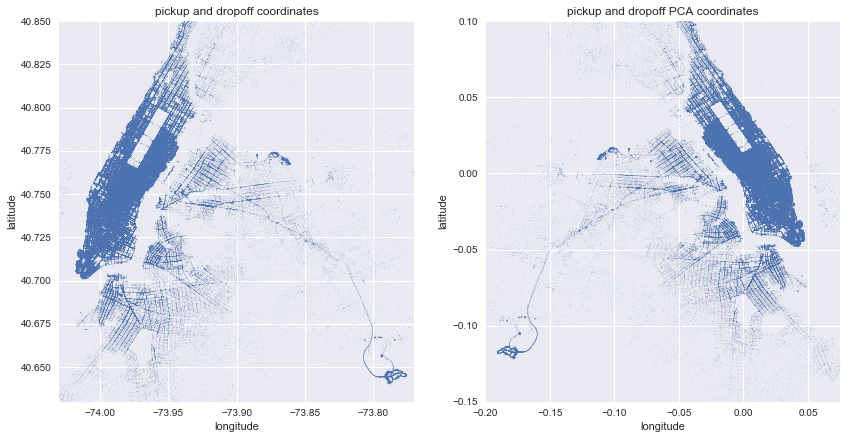

In [10]:
plt.figure(figsize = (14, 7))

plt.subplot(121)
plt.plot(list(df_train.pickup_longitude) + list(df_train.dropoff_longitude), 
         list(df_train.pickup_latitude) + list(df_train.dropoff_latitude),
         '.', alpha = 0.4, markersize = 0.5)

plt.title('pickup and dropoff coordinates')
plt.xlim(min_lo, max_lo)
plt.ylim(min_la, max_la)
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.subplot(122)
plt.plot(list(df_train.pickup_pca0) + list(df_train.dropoff_pca0), 
         list(df_train.pickup_pca1) + list(df_train.dropoff_pca1),
         '.', alpha = 0.4, markersize = 0.5)

plt.title('pickup and dropoff PCA coordinates')
plt.xlim(-0.2, 0.075)
plt.ylim(-0.15, 0.1)
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.show()

# Clustering

Splitting New York City up in clusters allows to extract averaged speed and trip durations featured grouped by the clusters. The feature extraction part is replaced using a more complex aggregation also using time later.

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=150)
kmeans.fit(df_train[['pickup_longitude', 'pickup_latitude']].head(n = 200000))

df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_longitude', 'pickup_latitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_longitude', 'dropoff_latitude']])

df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_longitude', 'pickup_latitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_longitude', 'dropoff_latitude']])

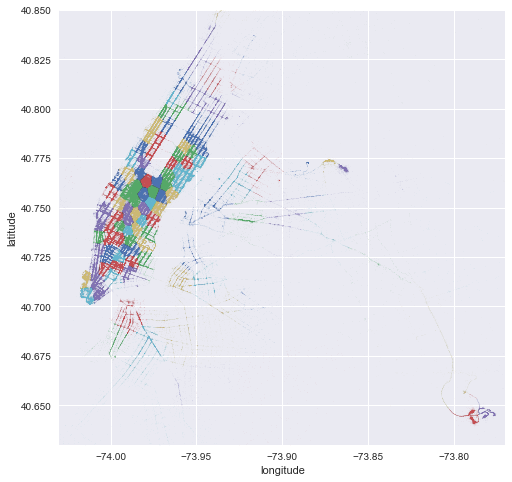

In [12]:
plt.figure(figsize = (8, 8))

for cluster in df_train.pickup_cluster.unique():
    plt.plot(df_train.pickup_longitude[df_train.pickup_cluster == cluster],
             df_train.pickup_latitude[df_train.pickup_cluster == cluster],
             '.', alpha = 0.3, markersize = 0.5)

plt.xlim(min_lo, max_lo)
plt.ylim(min_la, max_la)
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.show()

# Time and date

In [13]:
import holidays
from datetime import date, datetime

us_holidays = holidays.UnitedStates()

def add_time_features(data):
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data.loc[:, 'pickup_hour'] = data['pickup_datetime'].dt.hour
    data.loc[:, 'pickup_minute'] = data['pickup_datetime'].dt.minute
    data.loc[:, 'pickup_date'] = data['pickup_datetime'].dt.date
    data.loc[:, 'pickup_dt'] = (data['pickup_datetime'] - data['pickup_datetime'].min()).dt.total_seconds()
    data.loc[:, 'pickup_dt_bin'] = (data['pickup_dt'] // (3 * 3600))
    
    data.loc[:, 'pickup_time'] = data.pickup_datetime.apply(lambda dt: dt.hour * 3600 + dt.minute * 60 + dt.second)
    data.loc[:, 'pickup_yearday'] = data.pickup_datetime.apply(lambda x: x.timetuple().tm_yday)
    data.loc[:, 'pickup_weekday'] = data.pickup_datetime.apply(datetime.weekday)
    data.loc[:, 'pickup_yearweek'] = data.pickup_datetime.apply(lambda x: x.isocalendar()[1])
    data.loc[:, 'holiday'] = data.pickup_datetime.apply(lambda x: 1 if x in us_holidays else 0)
    
    return data

df_train = add_time_features(df_train)
df_test = add_time_features(df_test)

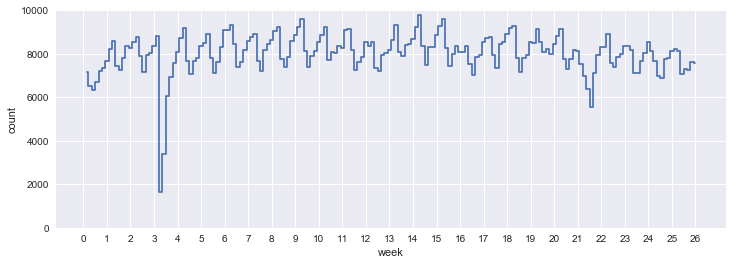

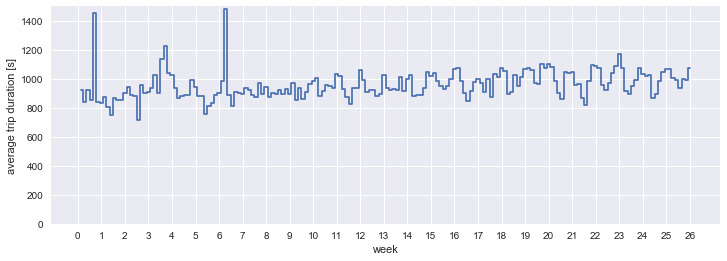

14884

In [14]:
df_train_gby_yearday = df_train.loc[:, ['pickup_yearday', 'trip_duration']] \
    .groupby('pickup_yearday').agg(['mean', 'count']).reset_index()
df_train_gby_yearday.columns = ['pickup_yearday', 'mean', 'count']

# amount of trip durations
plt.figure(figsize=(12, 4))
plt.step(df_train_gby_yearday.pickup_yearday, df_train_gby_yearday['count'], where = 'mid')

plt.xlabel('week')
plt.ylabel('count')
plt.xticks(range(0, 7*27, 7), range(0, 27))
plt.ylim(0, 10000)

plt.show()

# average trip duration
plt.figure(figsize=(12, 4))
plt.step(df_train_gby_yearday.pickup_yearday, df_train_gby_yearday['mean'], where = 'mid')

plt.xlabel('week')
plt.ylabel('average trip duration [s]')
plt.xticks(range(0, 7*27, 7), range(0, 27))
plt.ylim(0, 1500)

plt.show()

del df_train_gby_yearday
gc.collect()

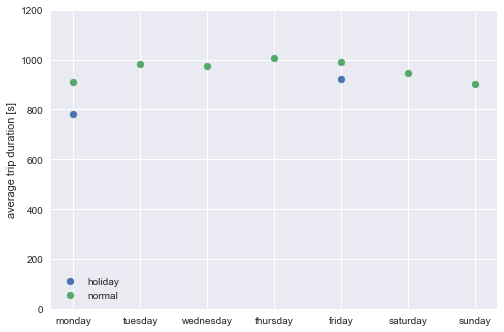

In [15]:
line_holiday = plt.scatter(data = df_train.loc[df_train['holiday'] == 1, ['pickup_weekday', 'trip_duration']] \
                                       .groupby('pickup_weekday', as_index = False).agg(np.mean), 
                           x = 'pickup_weekday', y = 'trip_duration', label = 'holiday')

line_noholiday = plt.scatter(data = df_train.loc[df_train['holiday'] == 0, ['pickup_weekday', 'trip_duration']] \
                                       .groupby('pickup_weekday', as_index = False).agg(np.mean), 
                             x = 'pickup_weekday', y = 'trip_duration', label = 'normal')

plt.legend(handles = [line_holiday, line_noholiday], loc = 3)
dict_weekday = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 
                4: 'friday', 5: 'saturday', 6: 'sunday'}
plt.xticks([k for k in dict_weekday.keys()], [v for v in dict_weekday.values()])

plt.ylim(0, 1200)
plt.ylabel('average trip duration [s]')

plt.show()

## Extreme weather

In [16]:
weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']

weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date
    
df_train['extreme_weather'] = df_train.pickup_date.apply(lambda x: 1 if x in weather_event.values else 0)
df_test['extreme_weather'] = df_test.pickup_date.apply(lambda x: 1 if x in weather_event.values else 0)

In [17]:
df_train.loc[:, ['extreme_weather', 'trip_duration']] \
            .groupby('extreme_weather', as_index = False).agg(np.mean)

,extreme_weather,trip_duration
0,0,966.126525
1,1,893.456647


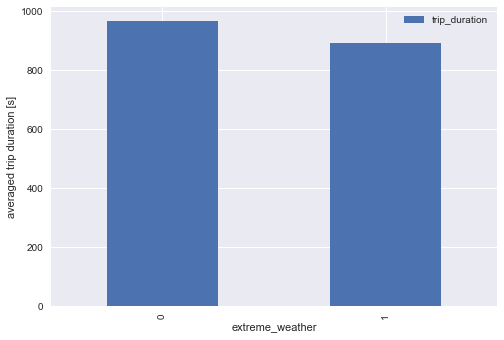

In [18]:
df_train.loc[:, ['extreme_weather', 'trip_duration']].groupby('extreme_weather').agg(np.mean) \
    .plot(kind = 'bar')

plt.ylabel('averaged trip duration [s]')
plt.show()

# OSRM dataset including fastest routes

This dataset was shared by oscarleo:  https://www.kaggle.com/c/nyc-taxi-trip-duration/discussion/37033. total_distance, total_travel_time and number_of_steps are some pretty nice features that can be directly used. More features will be extracted using this dataset later.

In [19]:
df_osrm_train = pd.concat([pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv'), 
                     pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv')])
df_osrm_test = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_test.csv')

df_osrm_train.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [20]:
df_train_merged = pd.merge(df_train, df_osrm_train, how = 'left', on = 'id')
df_test_merged = pd.merge(df_test, df_osrm_test, how = 'left', on = 'id')

del df_osrm_train
del df_osrm_test
gc.collect()

5355

In [21]:
len_bef = len(df_train_merged)
df_train_merged = df_train_merged[ df_train_merged.street_for_each_step \
                                       .apply(lambda x: True if isinstance(x, str) else False) ] 
print('Removed {} row without osrm information'.format(len_bef - len(df_train_merged)))

df_train_merged['street_for_each_step'] = df_train_merged.street_for_each_step.apply(str)

Removed 1 row without osrm information


In [24]:
# training sample indices with fastest route data
ind_fr = df_train_merged.total_travel_time > 0

print('{} rows without fastest route in training data'.format(len(df_train_merged[ ~ind_fr ])))
df_train_merged.loc[ind_fr, 'speed_osrm'] = df_train_merged.loc[ind_fr, 'total_distance'] \
                                          / df_train_merged.loc[ind_fr, 'trip_duration']
df_train_merged.loc[~ind_fr, 'speed_osrm'] = 0

6544 rows without fastest route in training data


# Geospatial and temporal aggregation

Due to the fact that the test sample does not contain future data some traffic features are extracted using grouping of coordinate and time features next. This is mostly taken from beluga's kernel aswell. 

In [25]:
def add_loc_binning(data):
    data.loc[:, 'center_latitude'] = (data['pickup_latitude'].values + data['dropoff_latitude'].values) / 2
    data.loc[:, 'center_longitude'] = (data['pickup_longitude'].values + data['dropoff_longitude'].values) / 2
    
    data.loc[:, 'pickup_lat_bin'] = np.round(data['pickup_latitude'], 3)
    data.loc[:, 'pickup_long_bin'] = np.round(data['pickup_longitude'], 3)

    data.loc[:, 'pickup_lat_bin'] = np.round(data['pickup_latitude'], 2)
    data.loc[:, 'pickup_long_bin'] = np.round(data['pickup_longitude'], 2)
    data.loc[:, 'center_lat_bin'] = np.round(data['center_latitude'], 2)
    data.loc[:, 'center_long_bin'] = np.round(data['center_longitude'], 2)
    
    return data

df_train_merged = add_loc_binning(df_train_merged)
df_test_merged = add_loc_binning(df_test_merged)

In [26]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_cluster', 'dropoff_cluster']:
    df_gby = df_train_merged.groupby(gby_col).mean()[['speed_osrm', 'trip_duration']]
    df_gby.columns = ['%s_gby_%s' % (col, gby_col) for col in df_gby.columns]
    df_train_merged = pd.merge(df_train_merged, df_gby, how='left', left_on = gby_col, right_index = True)
    df_test_merged = pd.merge(df_test_merged, df_gby, how='left', left_on = gby_col, right_index = True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    df_coord_speed = df_train_merged.groupby(gby_cols).mean()[['speed_osrm']].reset_index()
    df_coord_count = df_train_merged.groupby(gby_cols).count()[['id']].reset_index()
    
    df_coord_stats = pd.merge(df_coord_speed, df_coord_count, on = gby_cols)
    df_coord_stats.columns = gby_cols + ['speed_osrm_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    
    df_train_merged = pd.merge(df_train_merged, df_coord_stats, how='left', on=gby_cols)
    df_test_merged = pd.merge(df_test_merged, df_coord_stats, how='left', on=gby_cols)
    

group_freq = '60min'
df_all = pd.concat((df_train_merged, df_test_merged))#[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
df_train_merged.loc[:, 'pickup_datetime_group'] = df_train_merged['pickup_datetime'].dt.round(group_freq)
df_test_merged.loc[:, 'pickup_datetime_group'] = df_test_merged['pickup_datetime'].dt.round(group_freq)   

In [27]:
# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_' + str(group_freq)] = df_counts.isnull().rolling(group_freq).count()['id']
df_train_merged = df_train_merged.merge(df_counts, on = 'id', how = 'left')
df_test_merged = df_test_merged.merge(df_counts, on = 'id', how = 'left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all.set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']).agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean().drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})
    
# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_' + str(group_freq)] = df_counts.isnull().rolling(group_freq).count()['id']
df_train_merged = df_train_merged.merge(df_counts, on = 'id', how = 'left')
df_test_merged = df_test_merged.merge(df_counts, on = 'id', how = 'left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all.set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']).agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean().drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})
             
df_train_merged.loc[:, 'dropoff_cluster_count'] = df_train_merged[['pickup_datetime_group', 'dropoff_cluster']] \
    .merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left') \
    ['dropoff_cluster_count'].fillna(0)
df_test_merged.loc[:, 'dropoff_cluster_count'] = df_test_merged[['pickup_datetime_group', 'dropoff_cluster']] \
    .merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left') \
    ['dropoff_cluster_count'].fillna(0)

In [28]:
# Count how many trips are going from each cluster over time
df_full = pd.concat((df_train_merged, df_test_merged))[['id', 'pickup_datetime', 
                                                        'pickup_cluster', 'dropoff_cluster']]

pickup_counts = df_full.set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']).agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean().drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

df_train_merged.loc[:, 'pickup_cluster_count'] = df_train_merged[['pickup_datetime_group', 'pickup_cluster']] \
    .merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left') \
    ['pickup_cluster_count'].fillna(0)
df_test_merged.loc[:, 'pickup_cluster_count'] = df_test_merged[['pickup_datetime_group', 'pickup_cluster']] \
    .merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left') \
    ['pickup_cluster_count'].fillna(0)

## Estimating speed using fastest route

oscarleo shared a pretty nice dataset about the fastest routes of the trips: https://www.kaggle.com/c/nyc-taxi-trip-duration/discussion/37033 This dataset contains some features (total_distance, total_travel_time, number_of_steps) that improve the accuracy of a model by a pretty good amount. However such a valuable dataset may allow to extract more valuable features.

So the next part focuses on estimating the speed a trip will travel along its fastest route. This will be done by averaging the speed of all trips that have used the respective street. The distance one trip has travelled on one street will be used as a weight such that as longer one trip was on a street as more will it contribute to the street's speed average.

It can be expected that the average speed a trip will have on one street depends on the date (especially weekday) and time that trip happens. This will be explored first and so will the average speed on a street calculated for different groups of time.

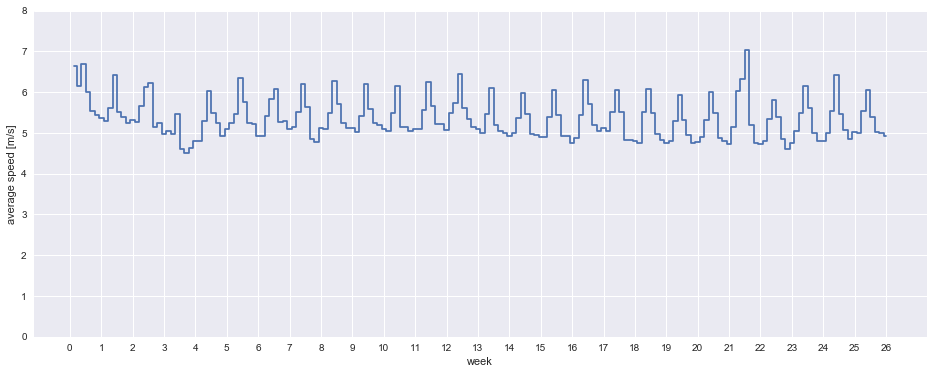

In [38]:
df_train_gby_yearday = df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20), 
                                           ['pickup_yearday', 'speed_osrm']] \
                           .groupby('pickup_yearday').agg(np.mean).reset_index()

plt.figure(figsize=(16, 6))
plt.step(df_train_gby_yearday.pickup_yearday, df_train_gby_yearday.speed_osrm, where = 'mid')

plt.xlabel('week')
plt.ylabel('average speed [m/s]')
plt.xticks(range(0, 7*27, 7), range(0, 27))
plt.ylim(0, 8)
plt.show()

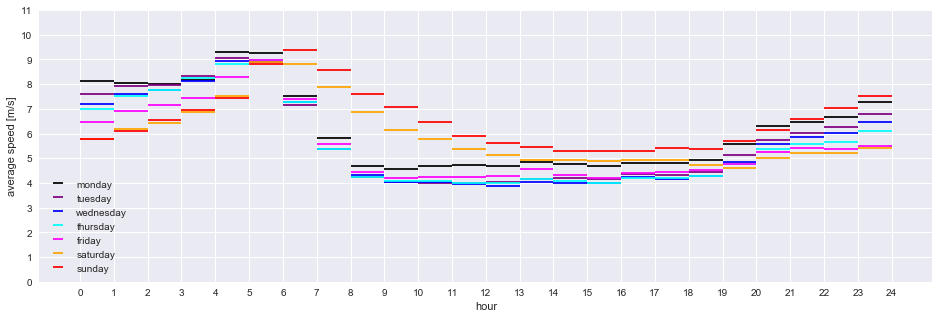

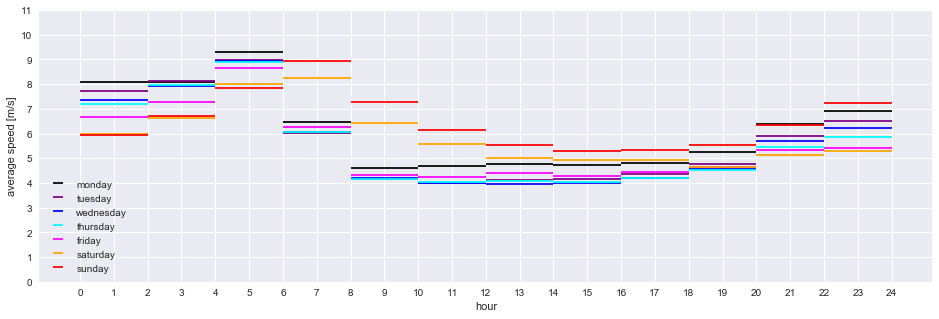

In [46]:
df_train_gby_hour_weekday = df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20), 
                                                ['pickup_hour', 'pickup_weekday', 'speed_osrm']] \
                                .groupby(['pickup_hour', 'pickup_weekday']).agg(np.mean).reset_index()

colors = ['black', 'purple', 'blue', 'cyan', 'magenta', 'orange', 'red']
plt.figure(figsize=(16, 5))
for d in range(7):
    plt.errorbar(x = df_train_gby_hour_weekday[ df_train_gby_hour_weekday.pickup_weekday == d ].pickup_hour + 0.5, 
                 y = df_train_gby_hour_weekday[ df_train_gby_hour_weekday.pickup_weekday == d ].speed_osrm, 
                 xerr = 0.5, marker = '', linestyle = '', label = dict_weekday[d], color = colors[d]
                )
plt.xlabel('hour')
plt.ylabel('average speed [m/s]')
plt.legend(loc = 0)
plt.ylim(0, 11)
plt.xticks(range(25))
plt.yticks(range(12))
plt.show()

df_train_merged.loc[:, 'pickup_hour_bin'] = np.floor(df_train_merged.pickup_time / (2*3600))
df_test_merged.loc[:, 'pickup_hour_bin'] = np.floor(df_test_merged.pickup_time / (2*3600))
df_train_gby_hour_weekday = df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20), 
                                                ['pickup_hour_bin', 'pickup_weekday', 'speed_osrm']] \
                        .groupby(['pickup_hour_bin', 'pickup_weekday']).agg(np.mean).reset_index()

#colors = ['black', 'purple', 'blue', 'cyan', 'magenta', 'orange', 'red']
plt.figure(figsize=(16, 5))
for d in range(7):
    plt.errorbar(x = df_train_gby_hour_weekday[ df_train_gby_hour_weekday.pickup_weekday == d ].pickup_hour_bin*2+1, 
                 y = df_train_gby_hour_weekday[ df_train_gby_hour_weekday.pickup_weekday == d ].speed_osrm, 
                 xerr = 1, marker = '', linestyle = '', label = dict_weekday[d], color = colors[d]
                )
plt.xlabel('hour')
plt.ylabel('average speed [m/s]')
plt.legend(loc = 0)
plt.ylim(0, 11)
plt.xticks(range(25))
plt.yticks(range(12))
plt.show()


One can see that the distribution for saturday and sunday are similar and the distributions for the remaining days are a little similar aswell. However tuesday, wednesday and thursday are closer to each other than they are to monday and friday. This can be partly explained by the fact that the only holidays in the first half of 2016 were on monday and on friday.

The evening (after 20:00) is different though. One would expect the distributions of friday and saturday are similar and that the distributions of the remaining ones are also similar. At least this is true for the first statement.

However calculating the average speed of each street for each hour bin for each day of a week would be very much so this will be reduced further. At first there will only 12 hour bins taken. The next plot will show that the information of the distributions differences is still very well contained. The second next plot will show that the average speed of mondays and fridays that were holidays (1st, 18th, 46th and 151th day of the year) is rather comparable to the weekend.

So the average speed of a street will be calculated in 12 different hour bins and 2 bins that represent whether the respective day is a working day or not. At least as long as the trip started before 20:00. If it started later the trip will only be categorized as a trip on a day without work if the next day is a saturday, sunday or holiday.

Furthermore all trips with speed larger than 20 m/s (72 km/h, 45 miles/h) will not be considered for the speed average calculations of a street. I don't know the actual speed limits in NYC but these can most likely be considered as wrong data.

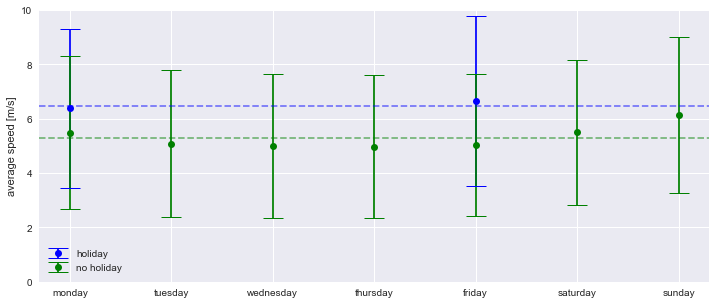

In [52]:
df_train_gby_weekday_hour = df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20), 
                                                ['pickup_weekday', 'holiday', 'speed_osrm']] \
                                .groupby(['pickup_weekday', 'holiday'])['speed_osrm'].agg([np.mean, np.std]) \
                                .reset_index()

plt.figure(figsize=(12, 5))
(_, caps, _) = plt.errorbar(data = df_train_gby_weekday_hour[ df_train_gby_weekday_hour.holiday == 1 ], 
               x = 'pickup_weekday', y = 'mean', yerr = 'std', capsize = 10,
               marker = 'o', linestyle = '', label = 'holiday', color = 'blue')

for cap in caps:
    cap.set_markeredgewidth(1)
    
(_, caps, _) = plt.errorbar(data = df_train_gby_weekday_hour[ df_train_gby_weekday_hour.holiday == 0 ], 
               x = 'pickup_weekday', y = 'mean', yerr = 'std', capsize = 10,
               marker = 'o', linestyle = '', label = 'no holiday', color = 'green')

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.axhline(y=np.mean(df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20) & (df_train_merged.holiday == 1), 
                                          'speed_osrm']), 
            color='blue', linestyle='dashed', alpha = 0.5)
plt.axhline(y=np.mean(df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20) & (df_train_merged.holiday == 0), 
                                          'speed_osrm']),  
            color='green', linestyle='dashed', alpha = 0.5)

plt.ylabel('average speed [m/s]')
plt.xticks([k for k in dict_weekday.keys()], [v for v in dict_weekday.values()])
plt.ylim(0, 10)
plt.legend(loc = 3)
plt.show()

The average speed of mondays and fridays that were holidays are closer to the average speed of sundays. Surprisingly even larger though the standard deviations are very large.

In [53]:
def add_work_feature(data):
    for i in range(len(data)):
        # not evening 
        if data.at[i, 'pickup_hour'] < 20:
            data.at[i, 'work'] = 1 if ((data.at[i, 'pickup_weekday'] < 5) & 
                                       (data.at[i, 'holiday'] == 0)
                                      ) else 0
        # evening
        else: 
            # is next day a holiday?
            if (data.at[i, 'pickup_yearday'] + 1) in [1, 18, 46, 151]:
                data.at[i, 'work'] = 0
            else:
                if data.at[i, 'pickup_weekday'] < 6:
                    data.at[i, 'work'] = 0 if ((data.at[i, 'pickup_weekday'] == 4) |
                                               (data.at[i, 'pickup_weekday'] == 5)
                                              ) else 1
                else:
                    data.at[i, 'work'] = 1
    return data

df_train_merged = add_work_feature(df_train_merged)
df_test_merged = add_work_feature(df_test_merged)

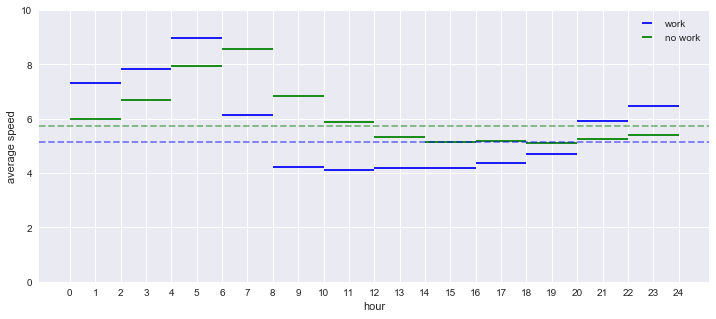

In [58]:
df_train_gby_work_hour = df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20), 
                                             ['work', 'pickup_hour_bin', 'speed_osrm']] \
                             .groupby(['work', 'pickup_hour_bin']).agg(np.mean).reset_index()

plt.figure(figsize=(12, 5))
plt.errorbar(x = df_train_gby_work_hour[ df_train_gby_work_hour.work == 1 ].pickup_hour_bin * 2 + 1, xerr = 1,
             y = df_train_gby_work_hour[ df_train_gby_work_hour.work == 1 ].speed_osrm, 
             marker = '', linestyle = '', label = 'work', color = 'blue')
plt.errorbar(x = df_train_gby_work_hour[ df_train_gby_work_hour.work == 0 ].pickup_hour_bin * 2 + 1, xerr = 1,
             y = df_train_gby_work_hour[ df_train_gby_work_hour.work == 0 ].speed_osrm, 
             marker = '', linestyle = '', label = 'no work', color = 'green')

plt.axhline(y=np.mean(df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20) \
                                          & (df_train_merged.work == 1), 'speed_osrm']), 
            color='blue', linestyle='dashed', alpha = 0.5)
plt.axhline(y=np.mean(df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20) \
                                          & (df_train_merged.work == 0), 'speed_osrm']),  
            color='green', linestyle='dashed', alpha = 0.5)

plt.xlabel('hour')
plt.ylabel('average speed')
plt.ylim(0, 10)
plt.xticks(range(25))
plt.legend()

plt.show()

### Calculate the average speed of a street

Create a DataFrame with one row per unique street, pickup_hour_bin and work category. This will be done by averaging the speed (calculated by trip_duration and total_travel_time) of all trips that belong to a specific street/pickup_hour_bin/work value. The distance the respective trip travelled on the particular street will be used as a weight for averaging.

In [61]:
df_speed_gby_hour_bin_day = df_train_merged[['pickup_hour_bin', 'work', 'speed_osrm']] \
                                .groupby(['pickup_hour_bin', 'work']).agg(np.mean)

lines =  df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20)].street_for_each_step.apply(lambda x: str(x).split(sep="|"))
streets = [item for l in lines for item in l]
print('{} unique streets used in training data'.format(len(set(streets))))

df_speed_gby_hour_bin_day_street = pd.DataFrame(index = df_speed_gby_hour_bin_day.index)
df_empty = df_speed_gby_hour_bin_day_street.copy()
df_speed_gby_hour_bin_day_street['street'] = ''
df_speed_gby_hour_bin_day_street.set_index('street', append=True, inplace=True)

for i in set(streets):
    df_i = df_empty.copy()
    df_i['street'] = i
    df_i = df_i.set_index('street', append = True)
    df_speed_gby_hour_bin_day_street = pd.concat([df_speed_gby_hour_bin_day_street, df_i])
    
df_speed_gby_hour_bin_day_street = \
    df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.index.get_level_values(2) != '' ]
df_speed_gby_hour_bin_day_street['speed'] = 0
df_speed_gby_hour_bin_day_street.head() 

6696 unique streets used in training data


speed
pickup_hour_bin work street              
0.0             0    Taylor Avenue      0
                1    Taylor Avenue      0
1.0             0    Taylor Avenue      0
                1    Taylor Avenue      0
2.0             0    Taylor Avenue      0

In [64]:
street_dict = {}
for i, s in enumerate(set(streets)):
    street_dict[s] = i

list_speed_gby_tds = [0.0] * 12 * 2 *len(set(streets))
list_speed_gby_tds_count = [0.0] * 12 * 2 *len(set(streets))

for i, row in enumerate(df_train_merged.loc[ind_fr & (df_train_merged.speed_osrm < 20)].itertuples()):
    speed = row.speed_osrm
    # use distnce travelled along this street as weight for the street's average
    weights = [float(k) for k in row.distance_per_step.split(sep="|")]
    sum_weight = sum(weights)
        
    if sum_weight > 0:
        for j, s in enumerate(row.street_for_each_step.split(sep="|")):
            index = int(street_dict[str(s)] * 24 + row.pickup_hour_bin * 2 + row.work)
            list_speed_gby_tds[index] += speed * weights[j] / sum_weight
            list_speed_gby_tds_count[index] += 1 * weights[j] / sum_weight
    if i % 250000 == 0:
        print(str(i) + ' rows iterated')
print('finished')

df_speed_gby_hour_bin_day_street.loc[:, 'speed'] = \
    [i/j if j > 0 else 0.0 for i,j in zip(list_speed_gby_tds, list_speed_gby_tds_count)]

0 rows iterated
250000 rows iterated
500000 rows iterated
750000 rows iterated
1000000 rows iterated
1250000 rows iterated
finished


/Users/Pepe/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [65]:
print('{} rows'.format(len(df_speed_gby_hour_bin_day_street)))
print('{} filled rows'.format(len(df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed > 0 ])))
df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed > 0 ].head()

160704 rows
59300 filled rows


speed
pickup_hour_bin work street                  
0.0             0    Taylor Avenue  17.908448
                1    Taylor Avenue  12.127845
1.0             1    Taylor Avenue   9.481654
2.0             1    Taylor Avenue   4.360485
3.0             0    Taylor Avenue  12.509288

There are a lot of street/hour bin/work bins that are still empty. This isn't too much of a problem due to the fact that the trips in the test dataset won't need this values very often. Nonetheless these empty bins will be dealt with.

So at first the calculated averaged speeds will be plotted to make sure that something didn't went very wrong.

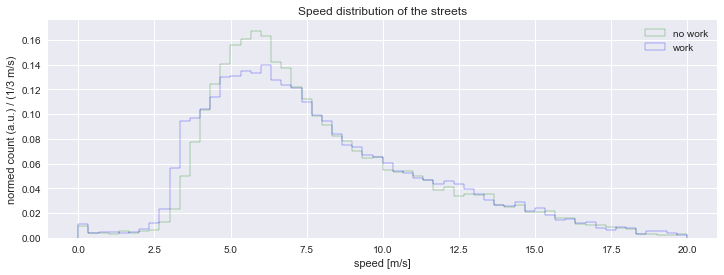

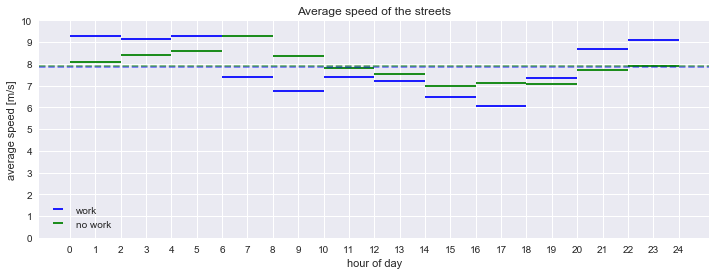

In [66]:
plt.figure(figsize=(12, 4))
df_speed_gby_hour_bin_day_street[ (df_speed_gby_hour_bin_day_street.speed > 0) &
                                  (df_speed_gby_hour_bin_day_street.index.get_level_values(1) == 0 )
                                ].speed.hist(bins = 60, alpha = 1.0, color = 'green', 
                                             histtype = 'step', label = 'no work', normed = True)
df_speed_gby_hour_bin_day_street[ (df_speed_gby_hour_bin_day_street.speed > 0) &
                                  (df_speed_gby_hour_bin_day_street.index.get_level_values(1) == 1 )
                                ].speed.hist(bins = 60, alpha = 1.0, color = 'blue', 
                                             histtype = 'step', label = 'work', normed = True)
plt.title('Speed distribution of the streets')
plt.legend()
plt.xlabel('speed [m/s]')
plt.ylabel('normed count (a.u.) / (1/3 m/s)')
plt.show()

plt.figure(figsize=(12, 4))
df_gby_hw = df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed > 0 ] \
                .groupby(['pickup_hour_bin', 'work']).agg(np.mean)

df_gby_hw_work = df_gby_hw[ df_gby_hw.index.get_level_values(1) == 1].reset_index()
df_gby_hw_nowork = df_gby_hw[ df_gby_hw.index.get_level_values(1) == 0].reset_index()

plt.errorbar(x = df_gby_hw_work.pickup_hour_bin*2+1, y = df_gby_hw_work.speed, marker='', 
            xerr = 1, color = 'blue', label = 'work', linestyle = '')
plt.axhline(y=np.mean(df_gby_hw_work.speed), color='blue', linestyle='dashed', alpha = 0.5)

plt.errorbar(x = df_gby_hw_nowork.pickup_hour_bin*2+1, y = df_gby_hw_nowork.speed, marker='', 
            xerr = 1, color = 'green', label = 'no work', linestyle = '')
plt.axhline(y=np.mean(df_gby_hw_nowork.speed), color='green', linestyle='dashed', alpha = 0.5)

plt.title('Average speed of the streets')
plt.legend(loc = 3)
plt.xlabel('hour of day')
plt.ylabel('average speed [m/s]')
plt.xticks(np.linspace(0,24,25))
plt.yticks(range(11))
plt.ylim(0, 10)
plt.show()

As mentioned earlier there are a lot of street/hour bin/work bins without an actual value. These missing values will now be estimated. At first the value of the other work category is used. If that one is missing aswell the mean of the different hour bins is used. If that isn't possible the mean of all streets is used.

Instead of using the mean of all hour bins in the second step it would most likely improve the result if just the mean of the adjacent hour bins would be used.

In [67]:
# speed of a street averaged over both work categories (using only bins with speed values greater than 0)
df_speed_gby_hour_bin_street = df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed > 0 ] \
                                  .groupby(['pickup_hour_bin', 'street']).agg(np.mean)
    
# speed average of a street using all bins with speed greater than 0
df_speed_gby_street = df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed > 0 ] \
                         .groupby('street').agg(np.mean)
    
# speed average of all streets with speed greater than 0
street_mean = np.mean(df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed > 0 ])
print('{} rows without speed value'.format(len(df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed == 0 ])))

indices = set(df_speed_gby_hour_bin_street.index)
df_speed_gby_hour_bin_day_street.speed = \
    df_speed_gby_hour_bin_day_street.apply(lambda x: df_speed_gby_hour_bin_street.loc[x.name[0], x.name[2]].speed 
                                          if ((x.name[0], x.name[2]) in indices) & (x.speed == 0) else x.speed, axis = 1)
print('{} rows without speed value'.format(len(df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed == 0 ])))

indices = set(df_speed_gby_street.index)
df_speed_gby_hour_bin_day_street.speed = \
    df_speed_gby_hour_bin_day_street.apply(lambda x: df_speed_gby_street.loc[x.name[2]].speed
                                          if (x.name[2] in indices) & (x.speed == 0) else x.speed, axis = 1)
print('{} rows without speed value'.format(len(df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed == 0 ])))

df_speed_gby_hour_bin_day_street.speed = \
    df_speed_gby_hour_bin_day_street.apply(lambda x: street_mean.values
                                           if x.speed == 0 else x.speed, axis = 1)
print('{} rows without speed value'.format(len(df_speed_gby_hour_bin_day_street[ df_speed_gby_hour_bin_day_street.speed == 0 ])))

101404 rows without speed value
86664 rows without speed value
1848 rows without speed value
0 rows without speed value


Spent time: 0:02:30.723885


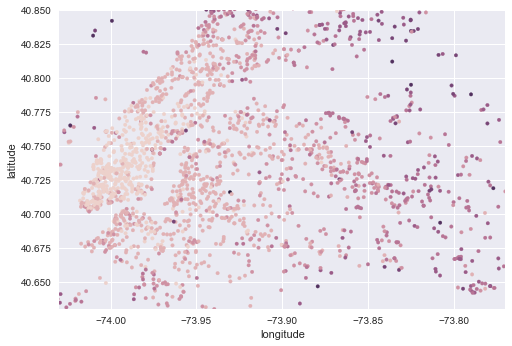

In [68]:
df_speed_gby_hour_bin_day_street['speed'] = df_speed_gby_hour_bin_day_street.speed.apply(lambda x: float(x)) 
df_street_loc = pd.DataFrame(df_speed_gby_hour_bin_day_street.groupby('street').agg(np.mean))
#df_street_loc.set_index('street', drop=True, inplace=True)

df_street_loc['longitude'] = 0.0
df_street_loc['latitude'] = 0.0

import datetime as dt

t0 = dt.datetime.now()
for i in range(len(df_train_merged.head(n=50000))):
    l = df_train_merged.iloc[i].step_location_list.split('|')
    for j, s in enumerate(df_train_merged.iloc[i].street_for_each_step.split('|')):
        df_street_loc.loc[s,'longitude'] = float(l[j].split(',')[0])
        df_street_loc.loc[s,'latitude'] = float(l[j].split(',')[1])

t1 = dt.datetime.now()
print('Spent time: ' + str(t1-t0))

from matplotlib.colors import ListedColormap

cmap = ListedColormap(sns.cubehelix_palette(8))

plt.scatter(data = df_street_loc[ (df_street_loc.speed > 4) & (df_street_loc.speed < 16)], 
            x = 'longitude', y = 'latitude', marker = '.', 
            c = 'speed', cmap = cmap, alpha = 1)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(min_lo, max_lo)
plt.ylim(min_la, max_la)
plt.show()

This plot shows the average speed of the streets. As brighter the point as lower is the average speed. As expected the average speed of streets in Manhattan are smallest and get larger as further away from Manhattan the street is. Please note that only a single (basically randomly selected) point is drawn for each street. So one doesn't see a nice pattern of NYC as one would see by drawing the pickup and dropoff locations.

### Estimating the average speed of a trip

The calculated average speed of a street will now be used to estimate the speed of all trips in the training and test datasets. Similar to before the distance fraction one trip has travelled on a specific street will be used as a weight for estimating the total average speed of the respective trip.

It will be taken care of cases where the average speed of a street isn't available such that the distance on that street is subtracted from the total distance of the trip for the weight calculation. This can happen if either no trip in the training data used this street or the rows in the training data were cut because its speed was above 20 m/s.

In [69]:
from itertools import compress

#df_train_merged = df_train_merged[ ~pd.isnull(df_train_merged.distance_per_step) ]

indices = set(df_speed_gby_hour_bin_day_street.index)
street_speed = df_speed_gby_hour_bin_day_street.speed.values

def extract_speed(x):
    we = [float(d) for d in x.distance_per_step.split(sep="|")]
    st = [s for s in x.street_for_each_step.split(sep="|")]
    bo = [(x.pickup_hour_bin, x.work, s) in indices for s in st]
    
    if (len(we) == len(st)):
        we = list(compress(we, bo))
        st = list(compress(st, bo))
        sum_we = sum(we)
        sp = 0.0
        if sum_we > 0:
            for w, s in zip(we, st):
                if (x.pickup_hour_bin, x.work, s) in indices:
                    index = int(street_dict[s] * 24 + x.pickup_hour_bin * 2 + x.work)
                    sp += street_speed[index] * w / sum_we
                else:
                    print('Cannot find indices, this shouldnt happen.')
        return sp
    else:
        print('Lengths are not equal, this shouldnt happen.')
        return -1.0

print('Starting')
t0 = dt.datetime.now()
train_estimated_speed = df_train_merged[['pickup_hour_bin', 'work', 'distance_per_step', 'street_for_each_step']] \
                            .apply(lambda x: extract_speed(x), axis = 1)
df_train_merged['estimated_speed'] = train_estimated_speed

t1 = dt.datetime.now()
print('Spent time: ' + str(t1-t0))

Starting
Spent time: 0:16:37.732971


In [70]:
print('Starting')
t0 = dt.datetime.now()
test_estimated_speed = df_test_merged[['pickup_hour_bin', 'work', 'distance_per_step', 
                                       'street_for_each_step']].apply(lambda x: extract_speed(x), axis = 1)
df_test_merged['estimated_speed'] = test_estimated_speed
    
t1 = dt.datetime.now()
print('Spent time: ' + str(t1-t0))

Starting
Spent time: 0:07:09.906691


In [73]:
df_train_merged[['speed_osrm', 'estimated_speed']].head()

,speed_osrm,estimated_speed
0,4.415604,3.919552
1,3.790649,4.912108
2,5.207533,5.880824
3,4.147786,4.406758
4,3.712414,4.978953


### Exploring the estimated speed
The estimated speed will now be compared with the speed (calculated by the trip_duration and the total_distance variables). In addition the estimated speed distributions of the training and test data will be compared to each other.

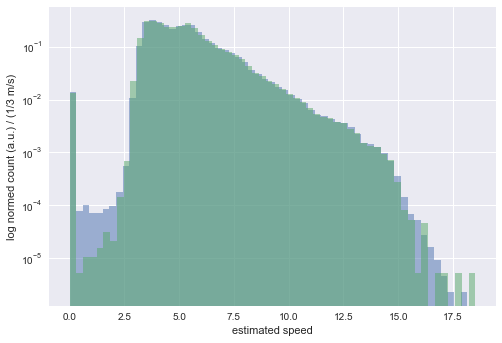

In [74]:
df_train_merged.estimated_speed.hist(bins = 60, normed=True, alpha=0.5, label = 'training sample')
df_test_merged.estimated_speed.hist(bins = 60, normed=True, alpha=0.5, label = 'test sample')

plt.yscale('log')
plt.xlabel('estimated speed')
plt.ylabel('log normed count (a.u.) / (1/3 m/s)')
plt.show()

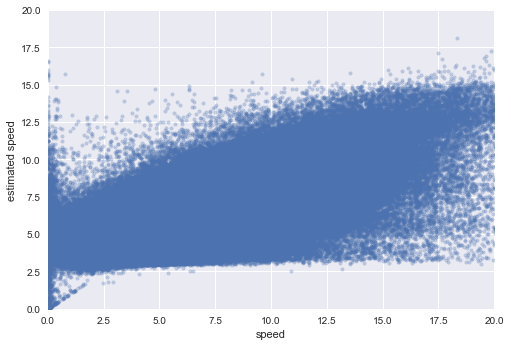

In [77]:
plt.scatter(data = df_train_merged, x = 'speed_osrm', y = 'estimated_speed', marker = '.', alpha = 0.3)

plt.xlabel('speed')
plt.ylabel('estimated speed')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

### Estimating trip duration
The estimated speed together with the total distance (of the fastest route dataset) allows to estimated the trip duration aswell. This estimated trip duration actually scores ~0.55 on the leaderboard without any machine learning at all.

In [78]:
ind = df_train_merged.estimated_speed > 0
df_train_merged.loc[ind, 'estimated_trip_duration'] = df_train_merged.total_distance.loc[ind] \
                                                    / df_train_merged.estimated_speed.loc[ind]
df_train_merged.loc[~ind, 'estimated_trip_duration'] = 0

ind = df_test_merged.estimated_speed > 0
df_test_merged.loc[ind,'estimated_trip_duration'] = df_test_merged.total_distance.loc[ind] \
                                                  / df_test_merged.estimated_speed.loc[ind]                                    
df_test_merged.loc[~ind,'estimated_trip_duration'] = 0

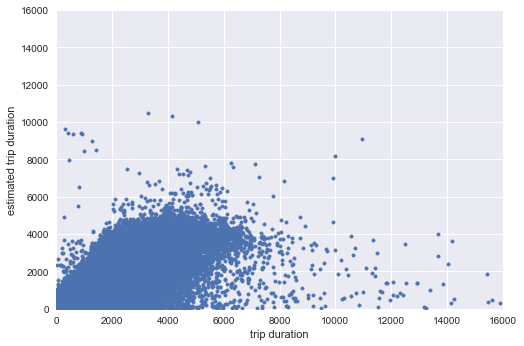

In [79]:
plt.scatter(data = df_train_merged, x = 'trip_duration', y = 'estimated_trip_duration', marker = '.')

plt.xlabel('trip duration')
plt.ylabel('estimated trip duration')
plt.xlim(0, 16000)
plt.ylim(0, 16000)
plt.show()

In many cases the trip duration is much larger than the estimated trip duration. This isn't surprising. But cases where the opposite is true are surprising. But in that cases the actual speed is very unrealistic:

In [81]:
df_train_merged.loc[((df_train_merged.estimated_trip_duration > 5000) & (df_train_merged.trip_duration < 2000)) |
                    ((df_train_merged.estimated_trip_duration > 3000) & (df_train_merged.trip_duration < 1000)),
                    ['vendor_id', 'passenger_count', 'estimated_trip_duration', 'trip_duration',
                     'total_distance', 'speed_osrm']].head(n = 10)

,vendor_id,passenger_count,estimated_trip_duration,trip_duration,total_distance,speed_osrm
166113,1,1,3670.643475,892,23099.7,25.896525
184925,1,1,5503.598398,792,69848.6,88.192677
191997,2,1,3238.401519,207,26773.2,129.339130
218935,2,6,7981.664991,461,88204.1,191.332104
244203,2,1,3263.800176,581,21132.2,36.372117
275644,1,4,9380.358046,875,58860.1,67.268686
283102,2,1,9390.554643,427,77702.8,181.973770
352325,2,1,3518.644440,840,29444.6,35.053095
377068,1,1,4902.040696,282,70838.0,251.198582
462727,2,1,3498.065211,720,28128.1,39.066806


### Comparing total_travel_time with estimated_trip_duration

Next the estimated trip duration will be compared with the total travel time (from the fastest route dataset) to ensure all this work wasn't for nothing. In such a case the linear dependency would have a slope of 1.

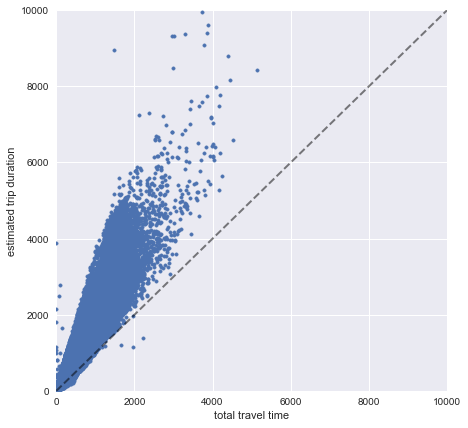

In [82]:
plt.figure(figsize=(7, 7))
plt.plot(np.linspace(0, 100000, 10000), np.linspace(0, 100000, 10000), '--', 
         linewidth=2, color = 'black', alpha = 0.5)
plt.scatter(data = df_train_merged[ df_train_merged.estimated_speed > 0 ],
            x = 'total_travel_time', y = 'estimated_trip_duration', marker = '.')

plt.xlabel('total travel time')
plt.ylabel('estimated trip duration')
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.show()

Luckily the slope is clearly different from 1. The next plot will compare which one of those 2 features models the real trip duration better.

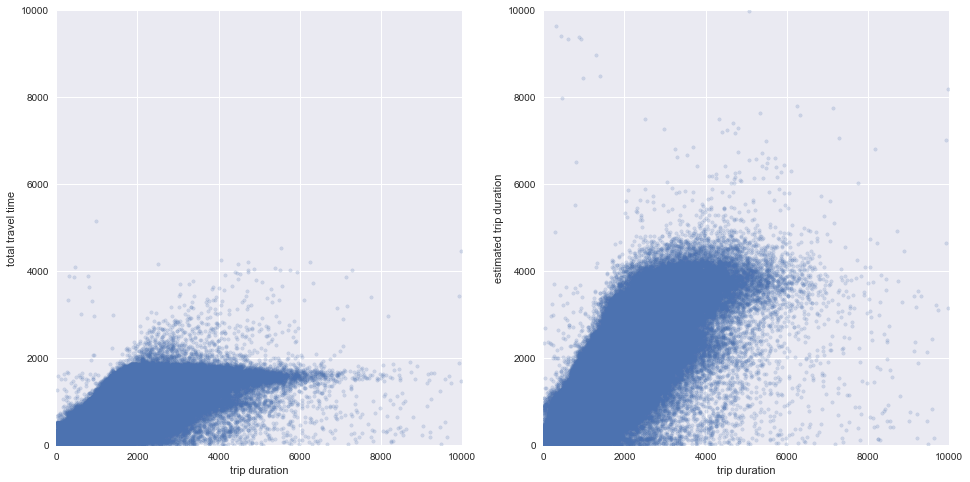

In [83]:
plt.figure(figsize=(16, 8))
df_temp = df_train_merged[ df_train_merged.estimated_speed > 0 ]

plt.subplot(121)
plt.scatter(x = df_temp.trip_duration,
            y = df_temp.total_travel_time,
            marker = '.', label = 'total travel time', alpha = 0.2)
plt.xlabel('trip duration')
plt.ylabel('total travel time')
plt.xlim(0, 10000)
plt.ylim(0, 10000)

plt.subplot(122)
plt.scatter(x = df_temp.trip_duration,
            y = df_temp.estimated_trip_duration,
            marker = '.', label = 'estimated trip duration', alpha = 0.2)
plt.xlabel('trip duration')
plt.ylabel('estimated trip duration')
plt.xlim(0, 10000)
plt.ylim(0, 10000)

#plt.legend()
plt.show()

Ideally the slope of the linear dependency of these 2 plots would be 1 again. As it turns out the estimated trip duration is closer to this than the total travel time is.

In [84]:
df_train_merged.to_csv('train_final.csv')
df_test_merged.to_csv('test_final.csv')

# Begin

In [322]:
df_train_merged = pd.read_csv('train_final.csv')
df_test_merged = pd.read_csv('test_final.csv')

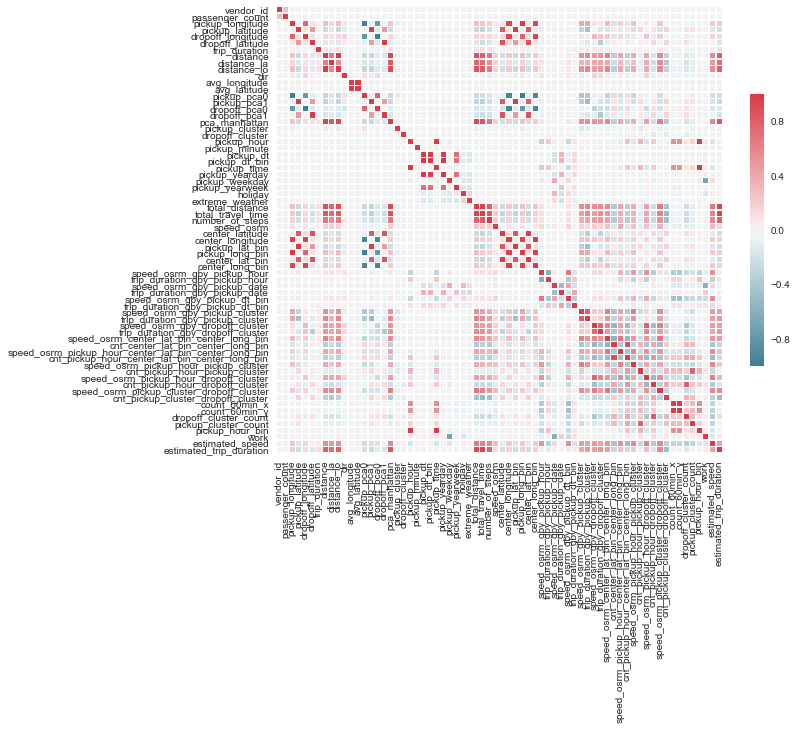

In [85]:
plt.figure(figsize = (10, 10))

corr = df_train_merged.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [87]:
def apply_cuts(data):
    #print(len(data))
    data = data[ (data['trip_duration'] < (7200)) & (data['trip_duration'] > 10) ]
    #data = data[ (data['trip_duration'] < (17000)) & (data['trip_duration'] > 10) ]
    #data = data[ ~((data['trip_duration'] < 60) & (data['distance'] < 1)) ]
    #data = data[ (data['passenger_count'] > 0 ) & (data['passenger_count'] <= 9) ]
    #data = data[ (data['passenger_count'] > 0) & (data['passenger_count'] <= 6) ]
    #data = data[ data.speed < 20 ]
    
    #data = data[ (data.pickup_longitude < max_lo)  & (data.pickup_longitude > min_lo) ]
    #data = data[ (data.pickup_latitude < max_la)   & (data.pickup_latitude > min_la) ]
    #data = data[ (data.dropoff_longitude < max_lo) & (data.dropoff_longitude > min_lo) ]
    #data = data[ (data.dropoff_latitude < max_la)  & (data.dropoff_latitude > min_la) ]
    
    #data = data[ data.estimated_speed < 20 ]
    
    return data

# Featuring

In [88]:
df_train_merged['log_trip_duration'] = np.log(df_train_merged['trip_duration'] + 1)

In [89]:
df_train_merged['store_and_fwd_flag'] = df_train_merged['store_and_fwd_flag'].apply(lambda x: 1 if (x == 'N') else 0)
df_test_merged['store_and_fwd_flag'] = df_test_merged['store_and_fwd_flag'].apply(lambda x: 1 if (x == 'N') else 0)

In [99]:
features = [ 'passenger_count', 'vendor_id', 'store_and_fwd_flag'
           , 'pickup_time', 'pickup_yearday', 'pickup_yearweek', 'pickup_weekday'#, 'pickup_month'
           , 'pickup_hour', 'pickup_minute'
           , 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
           , 'center_latitude', 'center_longitude', 'pickup_lat_bin', 'pickup_long_bin'
           , 'distance_lo', 'distance_la', 'distance'
           , 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'pca_manhattan'
           , 'dir'#,'dir_lo', 'dir_la'
           , 'extreme_weather' 
           , 'total_distance', 'total_travel_time', 'number_of_steps'
           , 'pickup_dt'
           , 'speed_osrm_gby_pickup_hour', 'trip_duration_gby_pickup_hour'
           , 'speed_osrm_gby_pickup_date', 'trip_duration_gby_pickup_date'
           , 'speed_osrm_gby_pickup_dt_bin', 'trip_duration_gby_pickup_dt_bin'
           , 'speed_osrm_gby_pickup_cluster', 'trip_duration_gby_pickup_cluster'
           , 'speed_osrm_gby_dropoff_cluster', 'trip_duration_gby_dropoff_cluster'
           , 'speed_osrm_center_lat_bin_center_long_bin', 'cnt_center_lat_bin_center_long_bin'
           , 'speed_osrm_pickup_hour_center_lat_bin_center_long_bin', 'cnt_pickup_hour_center_lat_bin_center_long_bin'
           , 'speed_osrm_pickup_hour_pickup_cluster', 'cnt_pickup_hour_pickup_cluster'
           , 'speed_osrm_pickup_hour_dropoff_cluster', 'cnt_pickup_hour_dropoff_cluster'
           , 'speed_osrm_pickup_cluster_dropoff_cluster', 'cnt_pickup_cluster_dropoff_cluster'
           , 'dropoff_cluster_count', 'pickup_cluster_count'
           , 'estimated_speed', 'estimated_trip_duration'#, 'count_60min'
           ]

label = ['log_trip_duration'] #['trip_duration']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train_merged, df_train_merged[label], 
                                                    test_size=0.2, random_state=42)
print('{} features'.format(len(features)))

55 features


In [100]:
X_train = apply_cuts(X_train)
y_train = y_train[ y_train.index.isin(X_train.index) ]
print('length X_train: ' + str(len(X_train)))
print('length y_train: ' + str(len(y_train)))

length X_train: 1163375
length y_train: 1163375


In [101]:
X_train = X_train[features]
X_test = X_test[features]

## Training vs test sample feature distribution comparision 

In [103]:
feature_stats = pd.DataFrame({'feature': features})
feature_stats.loc[:, 'train_mean'] = np.nanmean(df_train_merged[features].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(df_test_merged[features].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(df_train_merged[features].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(df_test_merged[features].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(df_train_merged[features].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(df_test_merged[features].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
26,extreme_weather,0.003118
41,speed_osrm_center_lat_bin_center_long_bin,0.003416
44,cnt_pickup_hour_center_lat_bin_center_long_bin,0.004185
49,speed_osrm_pickup_cluster_dropoff_cluster,0.004604
43,speed_osrm_pickup_hour_center_lat_bin_center_l...,0.005661


In [104]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
51,dropoff_cluster_count,0.0,0.000,0.000
50,cnt_pickup_cluster_dropoff_cluster,0.0,0.001,0.001
49,speed_osrm_pickup_cluster_dropoff_cluster,0.0,0.001,0.001
44,cnt_pickup_hour_center_lat_bin_center_long_bin,0.0,0.003,0.003
43,speed_osrm_pickup_hour_center_lat_bin_center_l...,0.0,0.003,0.003


# Fitting

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from lightgbm import LGBMRegressor

clf_lgb = LGBMRegressor(objective='regression', boosting_type = 'gbdt', metric = 'rmse', max_depth = -1, 
                    learning_rate = 0.05, n_estimators = 2000, num_leaves = 160, min_data_in_leaf = 700,
                    max_bin = 511
                   )

pl_lgb = Pipeline(steps=[('scaler', RobustScaler()), ('regressor', clf_lgb)])

import datetime as dt

def FitClassifier(pl, features):
    t0 = dt.datetime.now()
    pl.fit(X_train[features], y_train.values.ravel())
    t1 = dt.datetime.now()
    print('Spent time for training: ' + str(t1-t0))

def Predict(pl, X):
    p = np.exp(pl.predict(X)) - 1
    p[ p < 0 ] = 0
    return p

def rmsle(predicted, real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

def GetScore(pl, X, y):
    p = Predict(pl, X)
    s = rmsle(p, np.exp(np.array(y[label])) - 1)
    return s

In [94]:
FitClassifier(pl_lgb, features)
pred_lgb = Predict(pl_lgb, X_test)
print('lgb score: ' + str(rmsle(pred_lgb, np.exp(np.array(y_test[label])) - 1)))

Spent time for training: 0:14:20.065002
lgb score: [ 0.36488915]


In [83]:
from sklearn.externals import joblib

clfs_final = []
scores_final = []
pls_final = []
preds_final = []

t0 = dt.datetime.now()
for i in range(0, 20):
    clfs_final.append(LGBMRegressor(objective='regression', boosting_type = 'gbdt', metric = 'rmse', max_depth = -1, 
                    learning_rate = 0.05, n_estimators = 5000, num_leaves = 160, min_data_in_leaf = 700,
                    max_bin = 511, seed = i
                   ))
    pls_final.append(Pipeline(steps=[('scaler', RobustScaler()), ('regressor', clfs_final[-1])]))
    pls_final[-1].fit(X_train[features], y_train.values.ravel())
    
    joblib.dump(pls_final[-1], 'Pipeline_LGBM_2_{}.pkl'.format(i))
    
    print('Regressor {} trained.'.format(i))
    if len(y_test) > 0:
        preds_final.append(Predict(pls_final[-1], X_test))
        print('score: {:0.4f}'.format(rmsle(preds_final[-1], np.exp(np.array(y_test[label])) - 1)[0]))

if len(y_test) > 0:   
    print('comb score: {:0.4f}'.format(rmsle(np.mean(preds_final, axis=0), np.exp(np.array(y_test[label])) - 1)[0]))
t1 = dt.datetime.now()
print('Spent time: ' + str(t1-t0))

Regressor 4 trained.
Regressor 5 trained.
Regressor 6 trained.
Regressor 7 trained.
Regressor 8 trained.
Regressor 9 trained.
Regressor 10 trained.
Regressor 11 trained.
Regressor 12 trained.
Regressor 13 trained.
Regressor 14 trained.
Regressor 15 trained.
Regressor 16 trained.
Regressor 17 trained.
Regressor 18 trained.
Regressor 19 trained.
Spent time: 9:30:57.084342


## Feature Importance

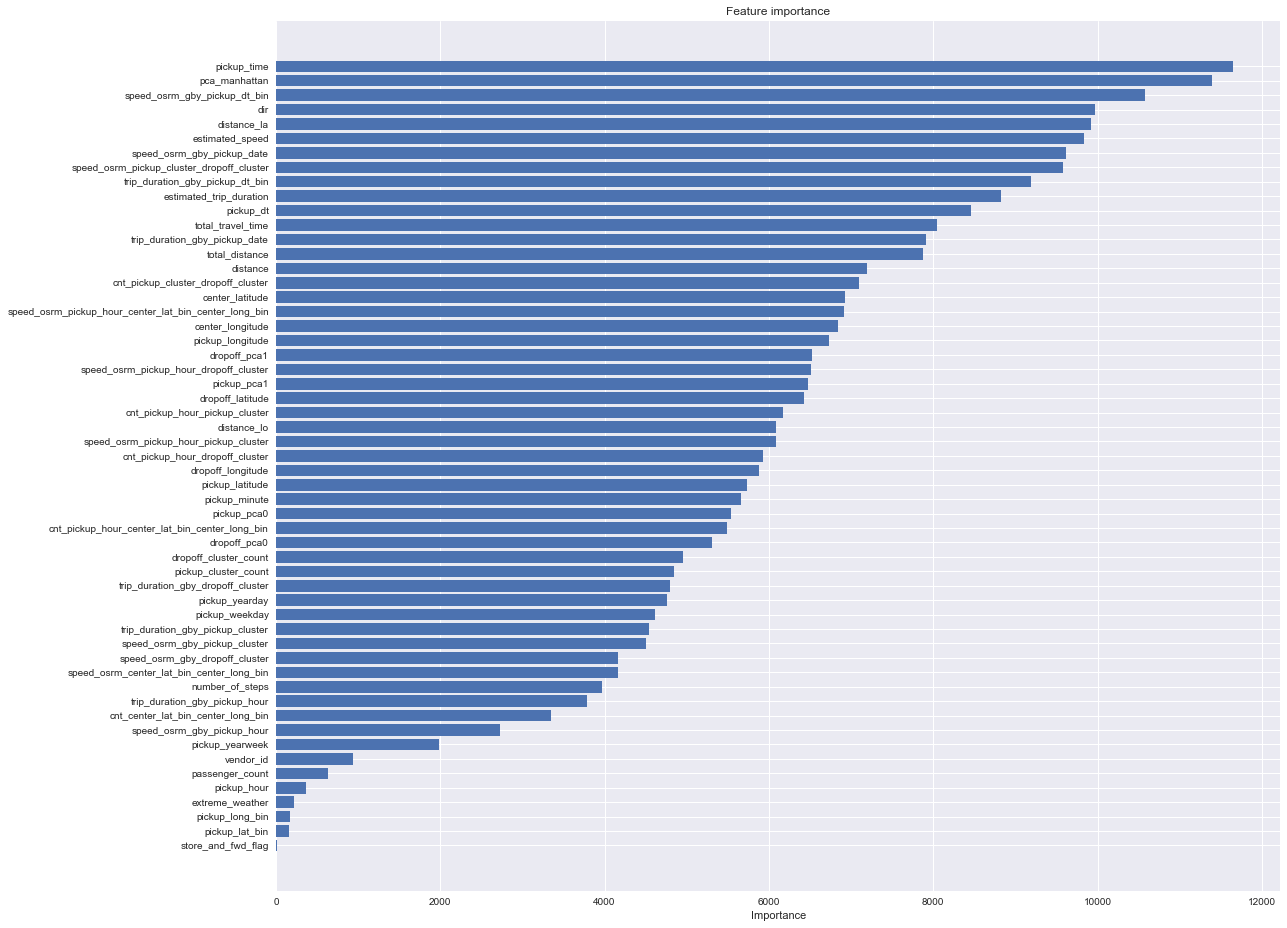

In [97]:
fig = plt.figure(figsize=(18, 16))

feature_importance = clf_lgb.feature_importances_#clfs_final[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')
plt.draw()
plt.show()

## Feature elimination score

Due to limited computing power less estimators and a higher learning_rate is used.

In [126]:
from sklearn.model_selection import cross_val_score

def score_rmsle(estimator, X, y):
    p = np.exp(estimator.predict(X)) - 1
    p[ p < 0 ] = 0
    s = rmsle(p, np.exp(y) - 1)
    return s

clf = LGBMRegressor(objective='regression', boosting_type = 'gbdt', metric = 'rmse', max_depth = -1, 
                    learning_rate = 0.1, n_estimators = 800, num_leaves = 160, min_data_in_leaf = 700,
                    max_bin = 512
                   )
pl = Pipeline(steps=[('scaler', RobustScaler()), ('regressor', clf)])

Scores_CV = pd.DataFrame({'feature': features, 'mean': 0, 'std': 0})
for i, f in enumerate(features):
    print('Training without ' + str(f))
    curr_features = [x for x in features if x not in f]

    cv_scores_f = cross_val_score(pl, df_train_merged[curr_features], df_train_merged[label].values.ravel(), 
                                  cv = 3, scoring = score_rmsle)

    Scores_CV.loc[Scores_CV.index[i], 'mean'] = np.mean(cv_scores_f)
    Scores_CV.loc[Scores_CV.index[i], 'std'] = np.std(cv_scores_f)
    print('test score: ' + str(np.mean(cv_scores_f)) + ' +- ' + str(np.std(cv_scores_f)))
    print('------------------------------------------------')

Training without passenger_count
test score: 0.365245793747 +- 0.000270007857092
------------------------------------------------
Training without vendor_id
test score: 0.3678136194 +- 0.000425851688159
------------------------------------------------
Training without store_and_fwd_flag
test score: 0.364666273978 +- 0.00014595085334
------------------------------------------------
Training without pickup_time
test score: 0.364962523633 +- 0.000217018230096
------------------------------------------------
Training without pickup_yearday
test score: 0.36473060092 +- 0.000347753695771
------------------------------------------------
Training without pickup_yearweek
test score: 0.364782507786 +- 0.00028244473777
------------------------------------------------
Training without pickup_weekday
test score: 0.365260874006 +- 0.000329425283574
------------------------------------------------
Training without pickup_hour
test score: 0.364653178262 +- 0.000319562516836
---------------------------

In [140]:
cv_scores = cross_val_score(pl, df_train_merged[features], df_train_merged[label].values.ravel(), 
                              cv = 3, scoring = score_rmsle)
print('test score: ' + str(np.mean(cv_scores)) + ' +- ' + str(np.std(cv_scores)))

test score: 0.36472364713 +- 0.000212858509913


In [141]:
cv_scores

array([ 0.36499997,  0.36468891,  0.36448206])

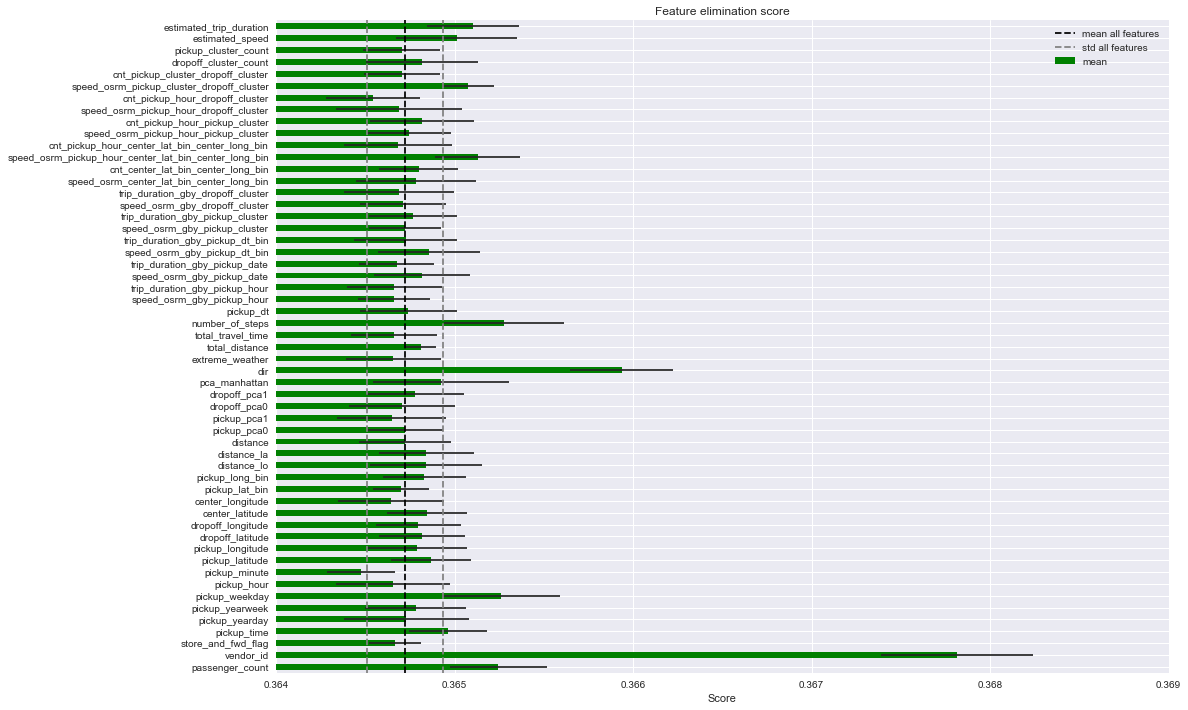

In [155]:
plt.figure(figsize = (16, 12))
Scores_CV.loc[:, ['mean']].plot(xerr = Scores_CV['std'], kind = 'barh', figsize = (16, 12), color = 'green')
plt.yticks(range(len(features)), features)
plt.xlim(0.364, 0.369)

plt.axvline(np.mean(cv_scores), linestyle='dashed', color='black', label = 'mean all features')
plt.axvline(np.mean(cv_scores) - np.std(cv_scores), linestyle='dashed', color='gray', label = 'std all features')
plt.axvline(np.mean(cv_scores) + np.std(cv_scores), linestyle='dashed', color='gray')

plt.title('Feature elimination score')
plt.xlabel('Score')
plt.legend()
#plt.savefig('FeatureEliminationScore.png')
plt.show()

In [145]:
#Scores_CV.to_csv('FeatureEliminationScores.csv')

### Replace NaN values in train data

In [ ]:
for c in df_train_merged.columns:
    if df_train_merged[c].isnull().values.any():
        print(c)
        mean = np.mean(df_train_merged[ ~df_train_merged[c].isnull() ][c])
        print('mean: ' + str(mean))
        print('len: ' + str(len(df_train_merged[ df_train_merged[c].isnull() ])))
        temp = df_train_merged[ df_train_merged[c].isnull() ].index.values
        #print('n: ' + str(len(temp)))
        df_train_merged[c].iloc[temp] = mean

# Tune LightGBM

Due to limited computing power parameters aren't tuned using a GridSearch

### Tune num_leaves and min_data_in_leaf

In [75]:
from sklearn.model_selection import cross_val_score

def score_rmsle(estimator, X, y):
    p = np.exp(estimator.predict(X)) - 1
    p[ p < 0 ] = 0
    s = rmsle(p, np.exp(y) - 1)
    return s

means = []
stds = []
for l in [32*1, 32*2, 32*3, 32*4, 32*5, 32*6]:
    for m in[300, 400, 500, 600, 700, 800]:
        clf = LGBMRegressor(objective='regression', boosting_type = 'gbdt', metric = 'rmse', max_depth = -1, 
                        learning_rate = 0.1, n_estimators = 1000, num_leaves = l, min_data_in_leaf = m
                       )
        pl = Pipeline(steps=[('scaler', ss), ('regressor', clf)])

        cv_scores = cross_val_score(pl, df_train_master[features], df_train_master[label].values.ravel(), 
                                    cv = 4, scoring = score_rmsle
                                   )

        me = np.mean(cv_scores)
        st = np.std(cv_scores)
        means.append(me)
        stds.append(st)

        print('num_leaves: {}, min_data_in_leaf: {}; score {:0.4f} +- {:0.4f}'.format(l, m, me, st))

num_leaves: 32, min_data_in_leaf: 300; score 0.3685 +- 0.0006
num_leaves: 32, min_data_in_leaf: 400; score 0.3684 +- 0.0007
num_leaves: 32, min_data_in_leaf: 500; score 0.3685 +- 0.0008
num_leaves: 32, min_data_in_leaf: 600; score 0.3685 +- 0.0008
num_leaves: 32, min_data_in_leaf: 700; score 0.3685 +- 0.0007
num_leaves: 32, min_data_in_leaf: 800; score 0.3685 +- 0.0008
num_leaves: 64, min_data_in_leaf: 300; score 0.3662 +- 0.0008
num_leaves: 64, min_data_in_leaf: 400; score 0.3659 +- 0.0008
num_leaves: 64, min_data_in_leaf: 500; score 0.3658 +- 0.0009
num_leaves: 64, min_data_in_leaf: 600; score 0.3658 +- 0.0007
num_leaves: 64, min_data_in_leaf: 700; score 0.3658 +- 0.0007
num_leaves: 64, min_data_in_leaf: 800; score 0.3658 +- 0.0008
num_leaves: 96, min_data_in_leaf: 300; score 0.3651 +- 0.0009
num_leaves: 96, min_data_in_leaf: 400; score 0.3648 +- 0.0009
num_leaves: 96, min_data_in_leaf: 500; score 0.3647 +- 0.0006
num_leaves: 96, min_data_in_leaf: 600; score 0.3646 +- 0.0008
num_leav

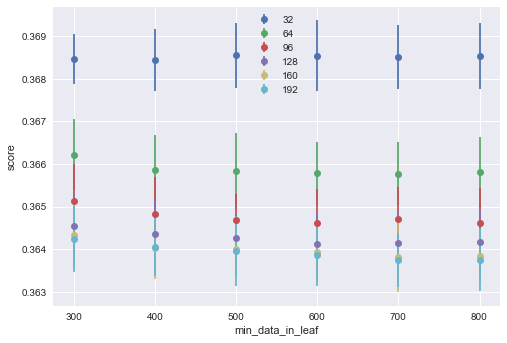

In [89]:
for i in range(6):
    plt.errorbar(x = [300, 400, 500, 600, 700, 800], y = means[i*6:(i+1)*6], marker = 'o', 
                 label = str((i+1)*32), yerr = stds[i*6:(i+1)*6], linestyle = '')
          
plt.xlabel('min_data_in_leaf')
plt.ylabel('score')
plt.legend()
#plt.ylim(0.36, 0.37)
plt.show()

### Tune max_bin parameter

In [165]:
means_lgb = []
stds_lgb = []
for b in [128*1-1, 128*2-1, 128*3-1, 128*4-1, 128*5-1, 128*6-1, 128*7-1, 128*8-1]:
    clf = LGBMRegressor(objective='regression', boosting_type = 'gbdt', metric = 'rmse', max_depth = -1, 
                        learning_rate = 0.1, n_estimators = 1000, num_leaves = 160, min_data_in_leaf = 700,
                        max_bin = b
                        )
    pl = Pipeline(steps=[('scaler', RobustScaler()), ('regressor', clf)])

    cv_scores = cross_val_score(pl, df_train_master[features], df_train_master[label].values.ravel(), 
                                    cv = 3, scoring = score_rmsle
                                   )

    me = np.mean(cv_scores)
    st = np.std(cv_scores)
    means_lgb.append(me)
    stds_lgb.append(st)

    print('b: {}; score {:0.4f} +- {:0.4f}'.format(b, me, st))

b: 127; score 0.3649 +- 0.0003
b: 255; score 0.3648 +- 0.0002
b: 383; score 0.3645 +- 0.0002
b: 511; score 0.3645 +- 0.0001
b: 639; score 0.3646 +- 0.0003
b: 767; score 0.3645 +- 0.0004
b: 895; score 0.3645 +- 0.0004
b: 1023; score 0.3648 +- 0.0002


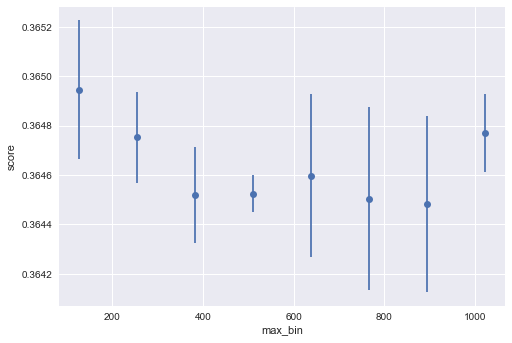

In [168]:
plt.errorbar(x = [128*1-1, 128*2-1, 128*3-1, 128*4-1, 128*5-1, 128*6-1, 128*7-1, 128*8-1], 
             y = means_lgb, yerr = stds_lgb, marker = 'o', linestyle = '')
plt.xlabel('max_bin')
plt.ylabel('score')
plt.show()

### Tune learning_rate parameter

In [170]:
means_lgb_l = []
stds_lgb_l = []
for l in [0.1, 0.05, 0.01]:
    clf = LGBMRegressor(objective='regression', boosting_type = 'gbdt', metric = 'rmse', max_depth = -1, 
                        learning_rate = l, n_estimators = 5000, num_leaves = 160, min_data_in_leaf = 700,
                        max_bin = 511
                        )
    pl = Pipeline(steps=[('scaler', RobustScaler()), ('regressor', clf)])

    cv_scores = cross_val_score(pl, df_train_master[features], df_train_master[label].values.ravel(), 
                                    cv = 3, scoring = score_rmsle
                                   )

    me = np.mean(cv_scores)
    st = np.std(cv_scores)
    means_lgb_l.append(me)
    stds_lgb_l.append(st)

    print('l: {}; score {:0.4f} +- {:0.4f}'.format(l, me, st))

l: 0.1; score 0.3694 +- 0.0003
l: 0.05; score 0.3643 +- 0.0002
l: 0.01; score 0.3646 +- 0.0002


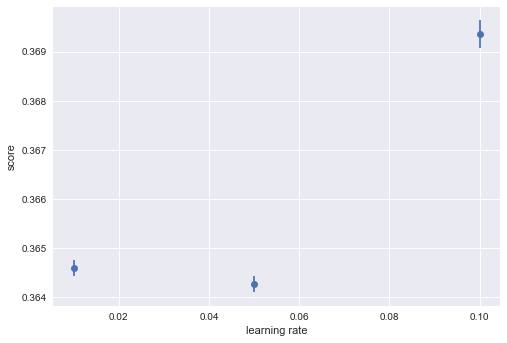

In [171]:
plt.errorbar(x = [0.1, 0.05, 0.01], y = means_lgb_l, yerr = stds_lgb_l, 
             marker = 'o', linestyle = '')
plt.xlabel('learning rate')
plt.ylabel('score')
plt.show()

# Predict test sample

In [89]:
for c in df_test_master.columns:
    if df_test_master[c].isnull().values.any():
        print(c)
        mean = np.mean(df_test_master[ ~df_test_master[c].isnull() ][c])
        print('mean: ' + str(mean))
        temp = df_test_master[ df_test_master[c].isnull() ].index.values
        df_test_master[c].iloc[temp] = mean

In [90]:
np.shape(df_train_master)

(1458643, 105)

In [91]:
from sklearn.externals import joblib

pls_final = []

for i in range(20):
    pls_final.append(joblib.load('Pipeline_LGBM_2_{}.pkl'.format(i)))

In [92]:
predictions_test = []

for pl in pls_final[len(predictions_test):]:
    predictions_test.append(Predict(pl, df_test_master[features]))

In [93]:
result = pd.DataFrame(df_test_master['id'])
result.set_index('id', inplace=True)
result['trip_duration'] = np.mean(predictions_test, axis = 0)

result.head()

,trip_duration
id,
id3004672,704.675896
id3505355,507.519507
id1217141,377.726568
id2150126,956.649323
id1598245,346.936923


In [94]:
result.to_csv('result.csv')

# Compare validation with test sample prediction

In [ ]:
nbins = 150

test_hist = plt.hist(result.trip_duration, bins=nbins, normed = True, alpha= 0.6)
valid_hist = plt.hist(pd.DataFrame(validation_predict), bins=nbins, normed = True, alpha=0.6)

plt.legend(['test sample', 'validation sample'])

plt.xlim(0,3000)
plt.xlabel('predicted trip duration')
plt.ylabel('rows (a.u.)')
plt.show()